In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import os
from training_utils import Augment_Less, plot_and_save_history, set_global_seed
import matplotlib.pyplot as plt

VOC_ROOT = "VOCdevkit/VOC2012"
IMAGE_DIR = os.path.join(VOC_ROOT, "JPEGImages")
LABEL_DIR = os.path.join(VOC_ROOT, "SegmentationClassRaw")
TRAIN_LIST = os.path.join(VOC_ROOT, "ImageSets", "Segmentation", "train.txt")
VAL_LIST   = os.path.join(VOC_ROOT, "ImageSets", "Segmentation", "val.txt")
    
set_global_seed(42)

def load_image_list(txt_path):
    with open(txt_path, 'r') as f:
        image_ids = f.read().strip().split()
    return image_ids

train_ids = load_image_list(TRAIN_LIST)
val_ids   = load_image_list(VAL_LIST)

def load_image(image_id):
    img_path = tf.strings.join([IMAGE_DIR, "/", image_id, ".jpg"])
    mask_path = tf.strings.join([LABEL_DIR, "/", image_id, ".png"])

    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.int32)


    image = tf.image.resize(image, (128, 128))
    mask  = tf.image.resize(mask, (128, 128), method='nearest')

    return image, mask

def create_dataset(image_ids, batch_size, shuffle=False, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices(image_ids)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


BATCH_SIZE = 16
EPOCHS = 40
OUTPUT_CLASSES = 21

augment_layer = Augment_Less(seed=42)

val_dataset = create_dataset(val_ids, batch_size=BATCH_SIZE, shuffle=False)

VAL_LENGTH   = len(val_ids)

VALIDATION_STEPS  = VAL_LENGTH // BATCH_SIZE


2024-12-17 17:03:02.673509: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-17 17:03:02.673531: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-12-17 17:03:02.673539: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-12-17 17:03:02.673566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-17 17:03:02.673580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
def masked_weighted_sparse_categorical_crossentropy(y_true, y_pred, class_weights, ignore_class=255):
    if len(y_true.shape) == 4 and y_true.shape[-1] == 1:
        y_true = tf.squeeze(y_true, axis=-1) 

    num_classes = len(class_weights)
    weights_vec = tf.constant([class_weights[c] for c in range(num_classes)], dtype=tf.float32)

    scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
    ce_per_pixel = scce(y_true, y_pred) 

    # Build valid_mask where label != ignore_class
    valid_mask = tf.not_equal(y_true, ignore_class)  

    # Also gather the class weight for each pixel
    y_true_clamped = tf.where(valid_mask, y_true, 0)  
    pixel_class_weights = tf.gather(weights_vec, tf.cast(y_true_clamped, tf.int32)) 

    ce_per_pixel = ce_per_pixel * pixel_class_weights

    # Zero out the invalid pixels
    ce_per_pixel = tf.where(valid_mask, ce_per_pixel, 0.0)

    # Average only over valid pixels
    valid_count = tf.reduce_sum(tf.cast(valid_mask, tf.float32)) + 1e-7
    ce = tf.reduce_sum(ce_per_pixel) / valid_count
    return ce

def masked_weighted_dice_loss_multiclass(y_true, y_pred, class_weights, ignore_class=255, smooth=1e-6):
    if len(y_true.shape) == 4 and y_true.shape[-1] == 1:
        y_true = tf.squeeze(y_true, axis=-1)  

    valid_mask = tf.not_equal(y_true, ignore_class)
    valid_mask_4d = tf.cast(tf.expand_dims(valid_mask, axis=-1), tf.float32)

    y_true_clamped = tf.where(valid_mask, y_true, 0)
    y_true_clamped = tf.cast(y_true_clamped, tf.int32)

    num_classes = 21  
    y_true_onehot = tf.one_hot(y_true_clamped, depth=num_classes)

    y_pred_prob = tf.nn.softmax(y_pred, axis=-1)

    weights_list = [class_weights[c] for c in range(num_classes)] 
    weights_vec = tf.constant(weights_list, dtype=tf.float32) 
    weights_broadcast = tf.reshape(weights_vec, [1, 1, 1, num_classes])

    intersection = tf.reduce_sum(valid_mask_4d * y_true_onehot * y_pred_prob * weights_broadcast, axis=[0,1,2])
    denom = (tf.reduce_sum(valid_mask_4d * y_true_onehot * weights_broadcast, axis=[0,1,2])
             + tf.reduce_sum(valid_mask_4d * y_pred_prob * weights_broadcast, axis=[0,1,2]))

    dice_per_class = (2.0 * intersection + smooth) / (denom + smooth)
    dice_mean = tf.reduce_mean(dice_per_class)
    return 1.0 - dice_mean

def masked_weighted_combined_loss(y_true, y_pred, class_weights, ignore_class=255):
    ce = masked_weighted_sparse_categorical_crossentropy(
        y_true, y_pred, class_weights, ignore_class
    )
    dice = masked_weighted_dice_loss_multiclass(
        y_true, y_pred, class_weights, ignore_class
    )
    return ce + dice

class_weights = {i: 1.0 for i in range(1,21)}
class_weights[0] = 0.5

@tf.keras.saving.register_keras_serializable()
def masked_weighted_combined_loss_wrapper(y_true, y_pred):
    return masked_weighted_combined_loss(
        y_true, y_pred, 
        class_weights=class_weights, 
        ignore_class=255
    )


model = tf.keras.models.load_model('unet_models_voc_less_augmentation/model_unet_pretrained_no_weights.keras')

2024-12-17 17:03:05.937548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 897ms/step


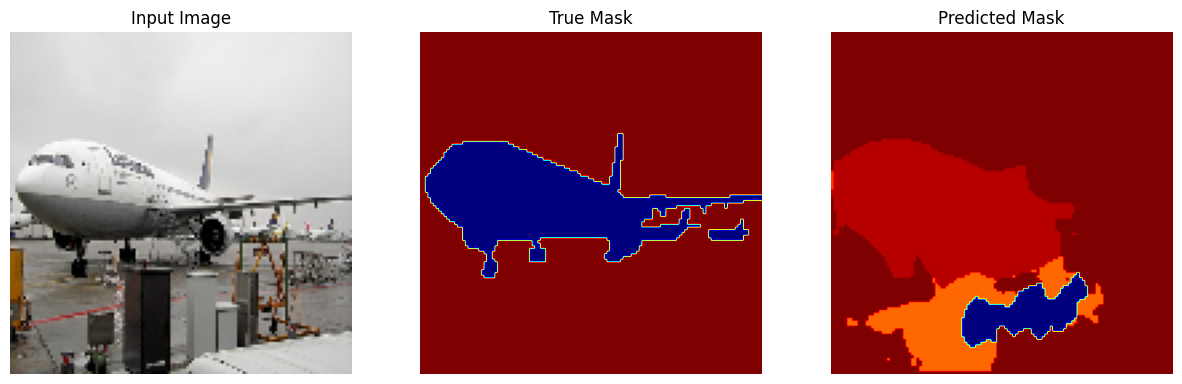

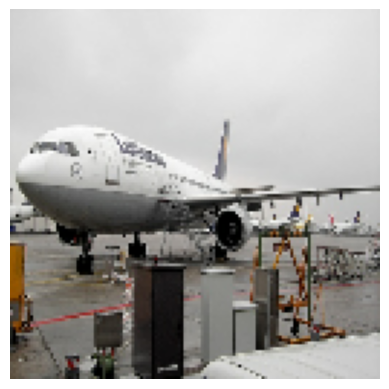

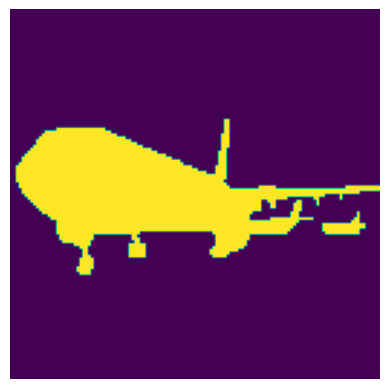

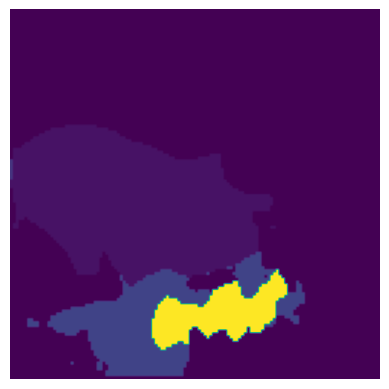

1/1 [==============================] - 0s 65ms/step


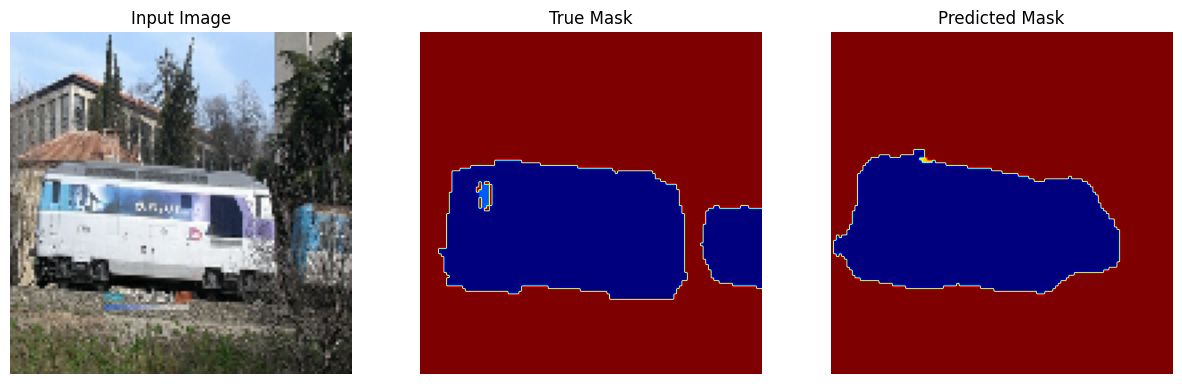

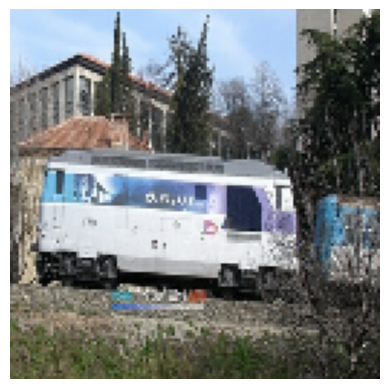

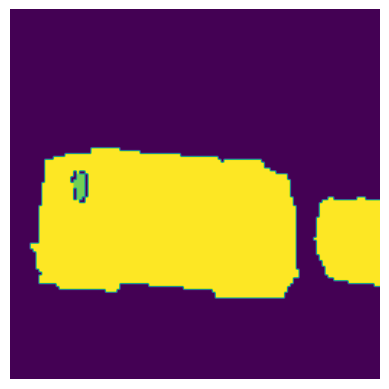

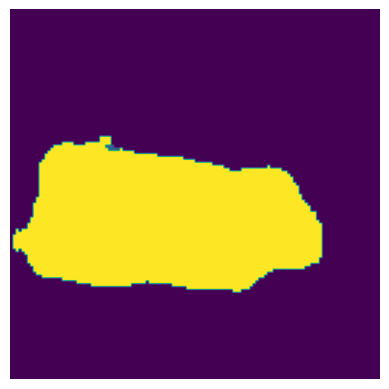

1/1 [==============================] - 0s 59ms/step


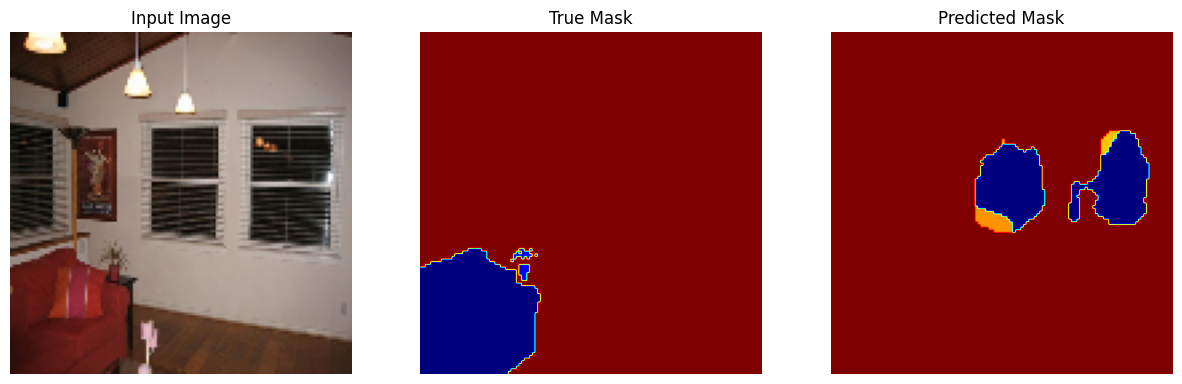

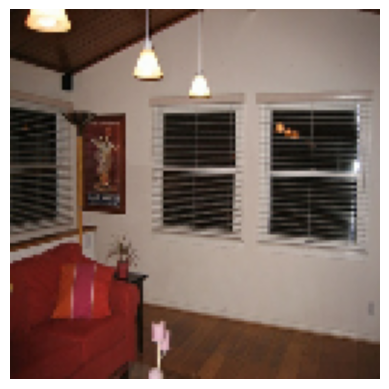

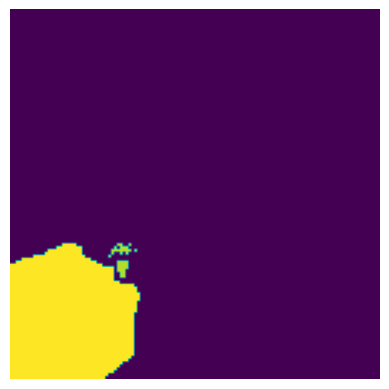

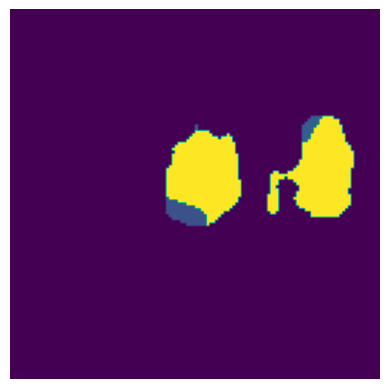

1/1 [==============================] - 0s 76ms/step


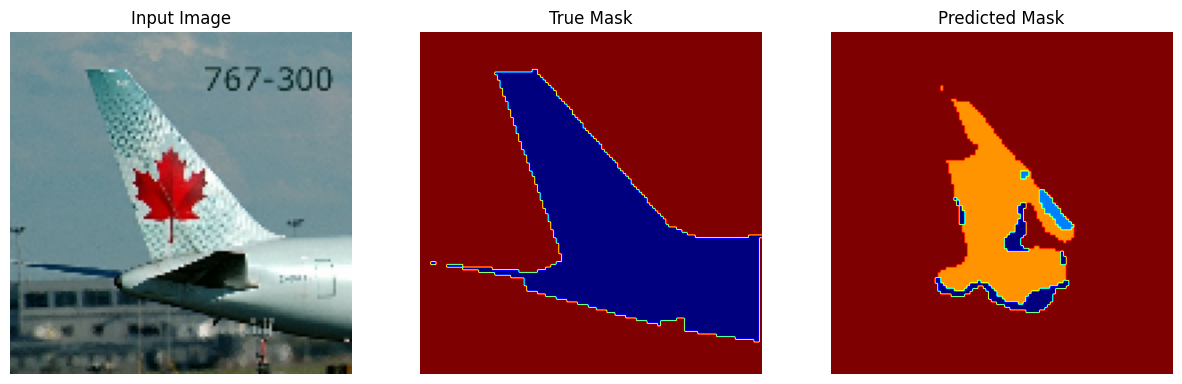

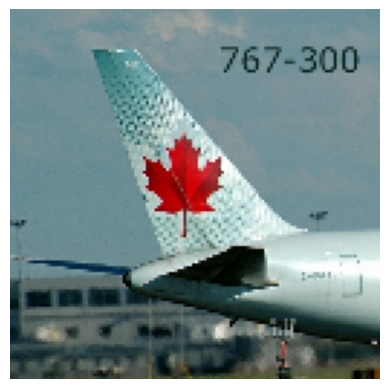

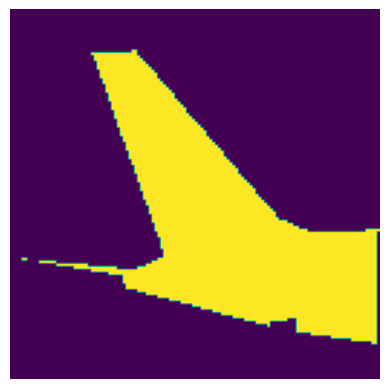

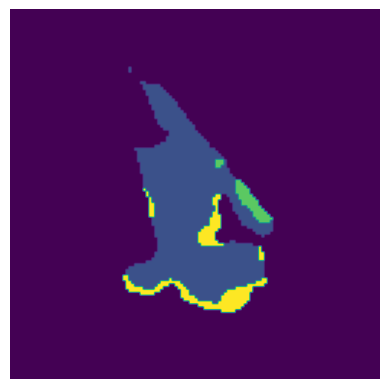

1/1 [==============================] - 0s 65ms/step


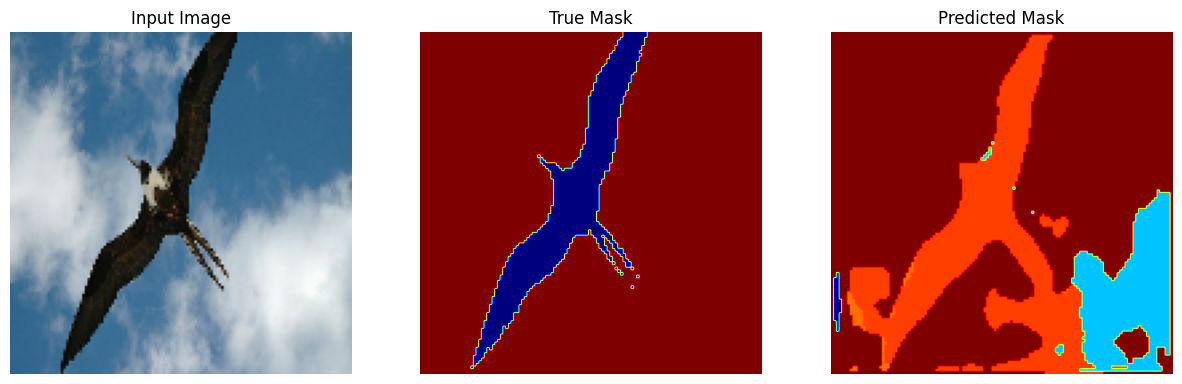

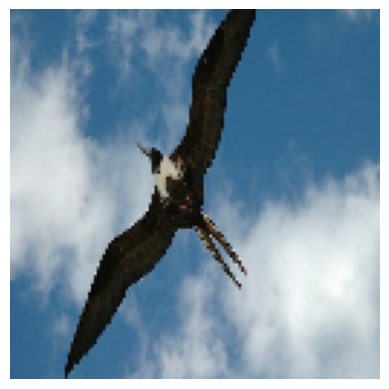

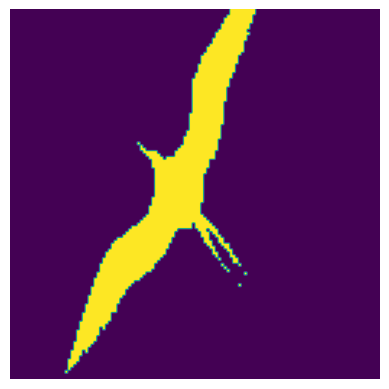

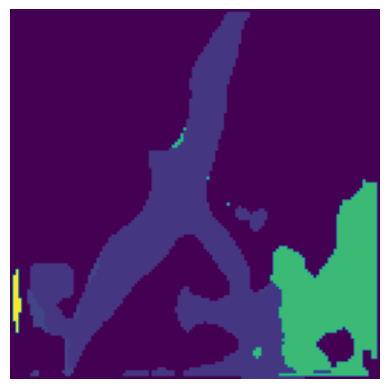

In [ ]:
def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)  
    return pred_mask[0]

def display(display_list):
    plt.figure(figsize=(15, 5))
    titles = ["Input Image", "True Mask", "Predicted Mask"]
    for i, item in enumerate(display_list):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        
        if len(item.shape) == 2:  
            item = tf.expand_dims(item, axis=-1)  
        plt.imshow(tf.keras.utils.array_to_img(item),cmap='jet_r')
        plt.axis('off')
    plt.show()


NUM_IMAGES_TO_SHOW = 5

for images, masks in val_dataset.take(NUM_IMAGES_TO_SHOW):
    masks = tf.where(masks == 255, 0, masks)
    pred = model.predict(images)   
    pred_mask = create_mask(pred)         

    display([images[0], masks[0], pred_mask]) 

    plt.imshow(tf.keras.utils.array_to_img(images[0]))
    plt.axis('off')
    plt.show()
    plt.imshow(tf.keras.utils.array_to_img(masks[0]))
    plt.axis('off')
    plt.show()
    plt.imshow(tf.keras.utils.array_to_img(tf.expand_dims(pred_mask, axis=-1)))
    plt.axis('off')
    plt.show()

In [4]:
model = tf.keras.models.load_model('fcn_model_voc_less_augmentation/model_batch_fcn_no_weights.keras')

1/1 [==============================] - 0s 244ms/step


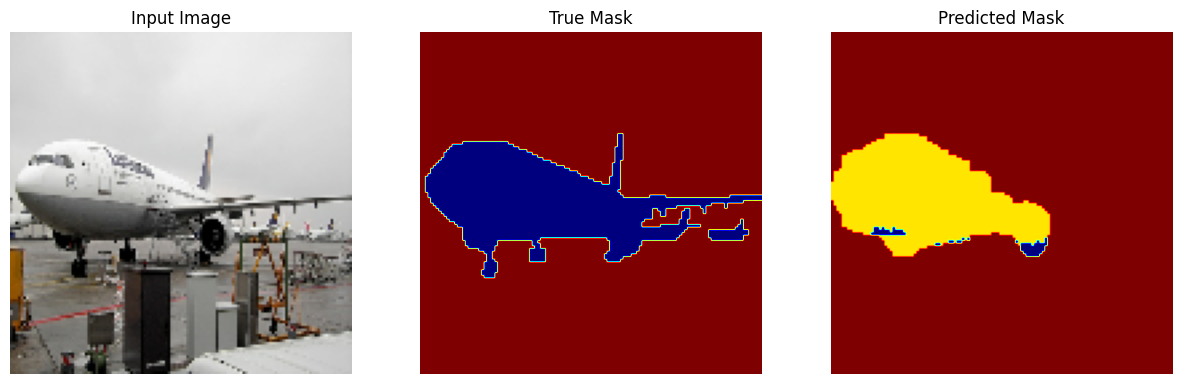

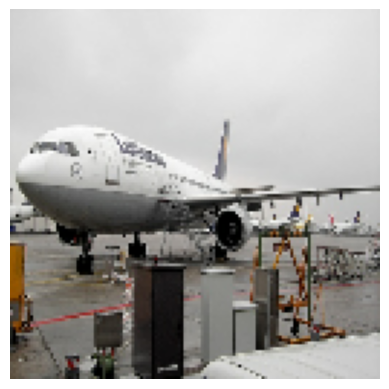

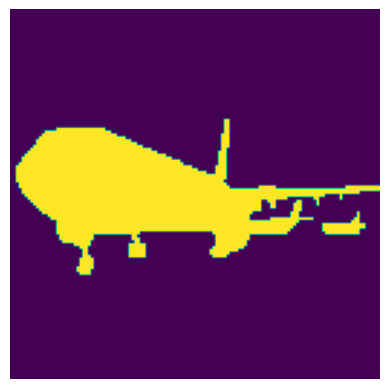

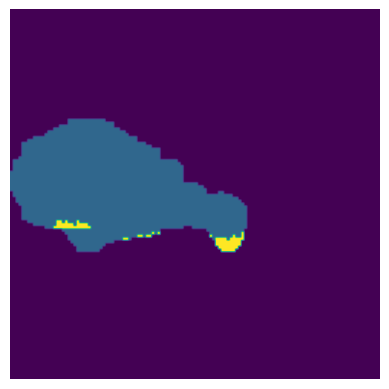

1/1 [==============================] - 0s 22ms/step


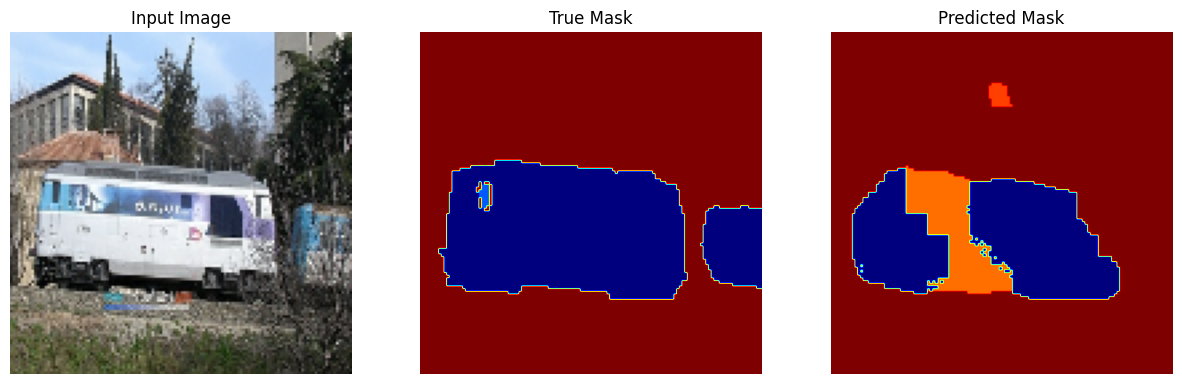

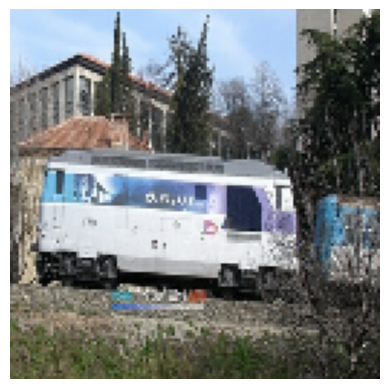

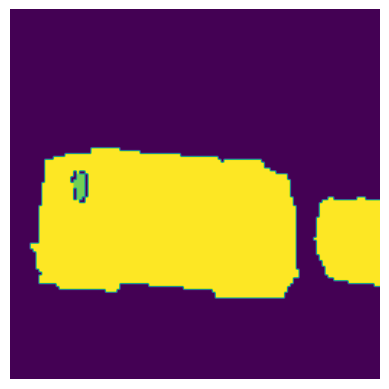

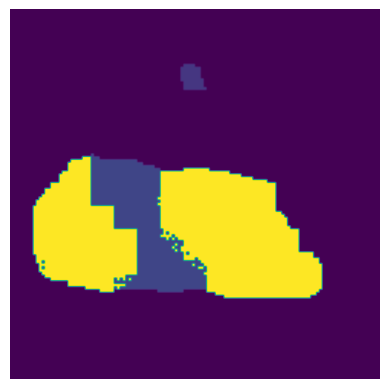

1/1 [==============================] - 0s 20ms/step


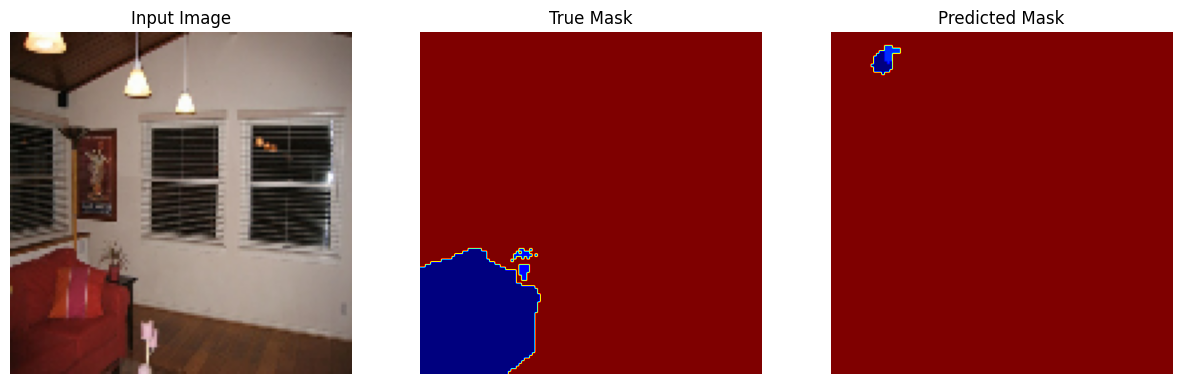

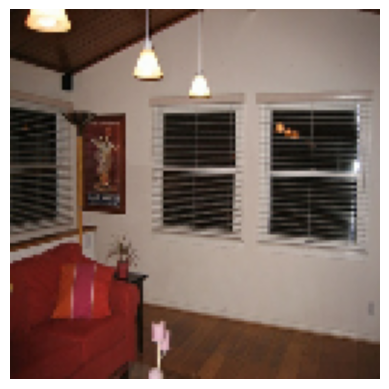

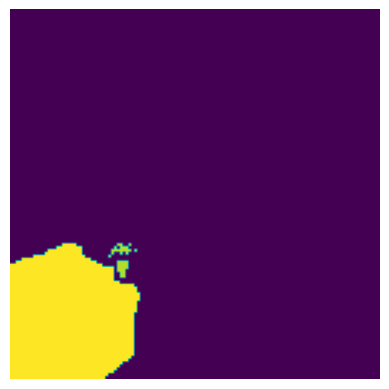

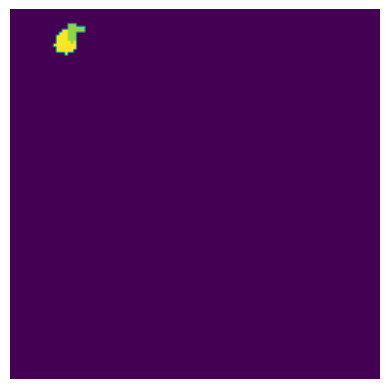

1/1 [==============================] - 0s 21ms/step


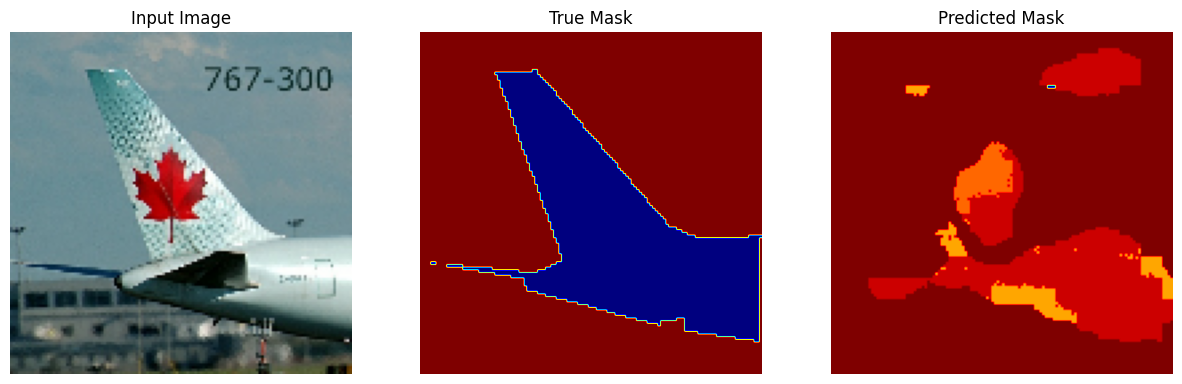

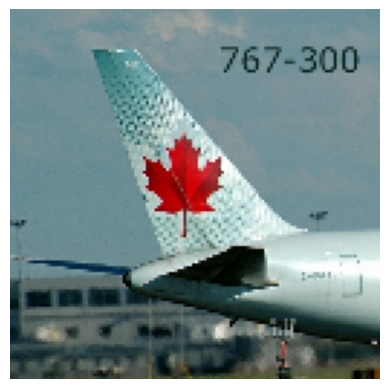

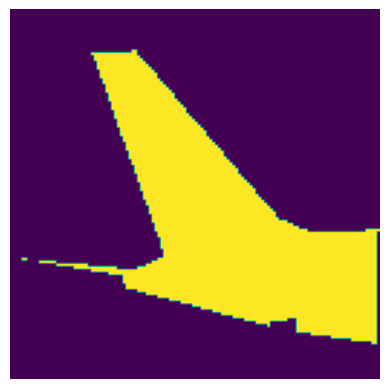

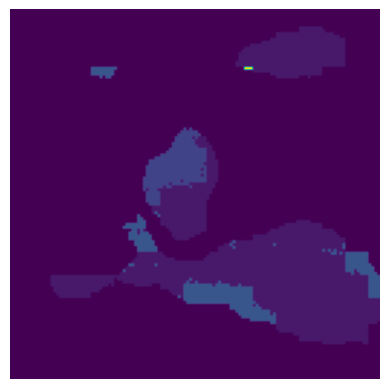

1/1 [==============================] - 0s 22ms/step


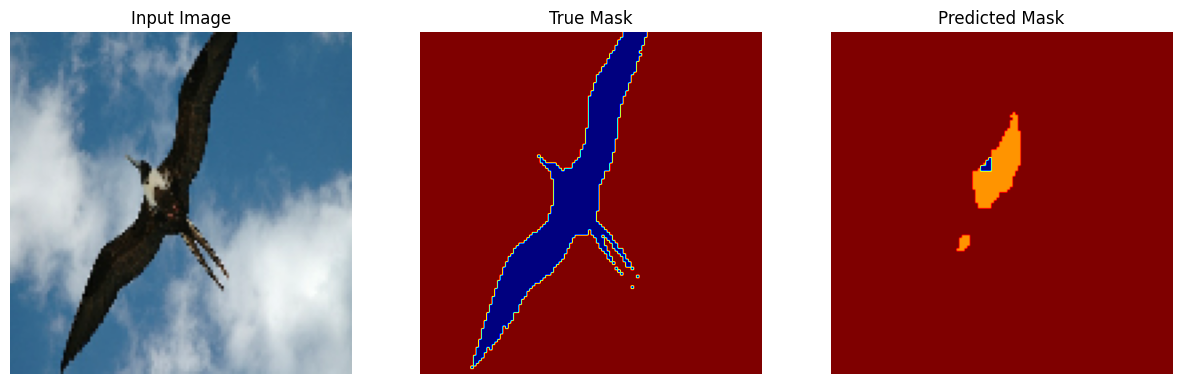

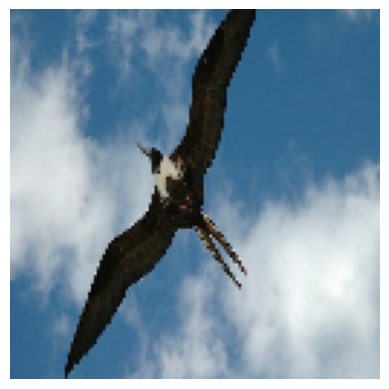

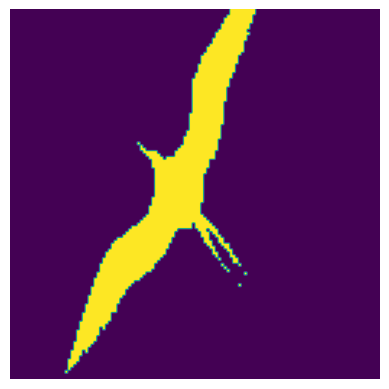

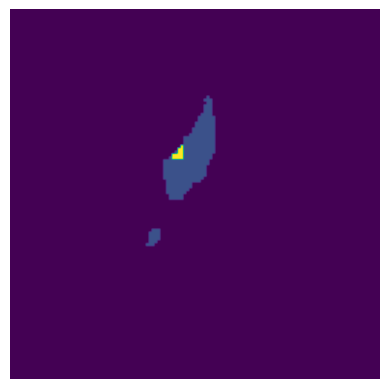

In [5]:
NUM_IMAGES_TO_SHOW = 5

for images, masks in val_dataset.take(NUM_IMAGES_TO_SHOW):
    masks = tf.where(masks == 255, 0, masks)
    pred = model.predict(images)   
    pred_mask = create_mask(pred)         

    display([images[0], masks[0], pred_mask]) 
    
    plt.imshow(tf.keras.utils.array_to_img(images[0]))
    plt.axis('off')
    plt.show()
    plt.imshow(tf.keras.utils.array_to_img(masks[0]))
    plt.axis('off')
    plt.show()
    plt.imshow(tf.keras.utils.array_to_img(tf.expand_dims(pred_mask, axis=-1)))
    plt.axis('off')
    plt.show()